<a href="https://colab.research.google.com/github/theouterlimitz/Earnings-Call-NLP-Analysis/blob/main/02_NLP_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Your Curated Data**


In [1]:
import pandas as pd

# Load your curated dataset
try:
    df_master = pd.read_pickle('amazon_earnings_calls_curated.pkl')
    print("Curated Amazon earnings call data loaded successfully.")
    print(f"Loaded {len(df_master)} transcripts.")
except FileNotFoundError:
    print("ERROR: 'amazon_earnings_calls_curated.pkl' not found. Please ensure it is uploaded to this session.")

Curated Amazon earnings call data loaded successfully.
Loaded 19 transcripts.


**Perform Sentiment Analysis**

Curated Amazon earnings call data loaded successfully.

Loading FinBERT sentiment analysis model...


Device set to use cpu


Model loaded successfully.

Analyzing sentiment for each earnings call transcript...
Processing results...

--- Sentiment Analysis Results ---
        date ticker sentiment_label  sentiment_score
0 2016-01-28   AMZN         neutral         0.867418
1 2016-04-28   AMZN         neutral         0.876643
2 2016-07-28   AMZN         neutral         0.864622
3 2016-10-27   AMZN         neutral         0.864858
4 2017-02-02   AMZN         neutral         0.860855

Plotting sentiment over time...


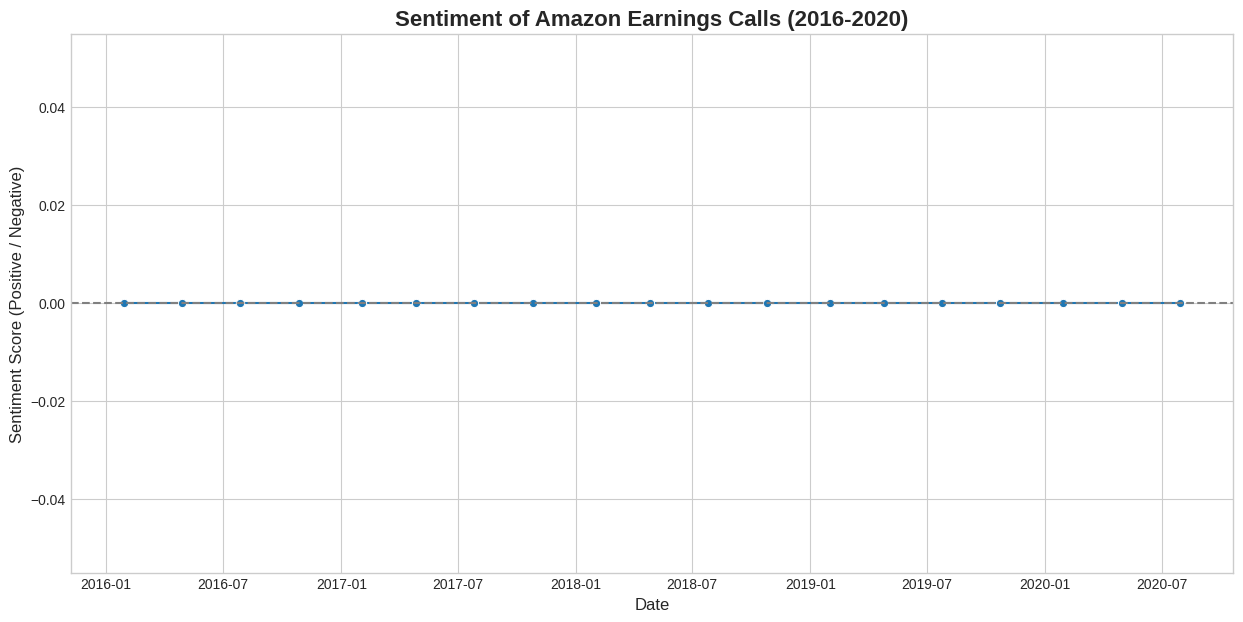

In [3]:
# Install the transformers library from Hugging Face and other dependencies
!pip install transformers torch sentencepiece -q

from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load your curated dataset ---
try:
    df_master = pd.read_pickle('amazon_earnings_calls_curated.pkl')
    print("Curated Amazon earnings call data loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'amazon_earnings_calls_curated.pkl' not found. Please ensure it is uploaded.")
    df_master = pd.DataFrame()

# ===================================================================
# ---  Perform Sentiment Analysis with a Transformer Model ---
# ===================================================================

if not df_master.empty:
    # 1. Load a pre-trained Sentiment Analysis model
    print("\nLoading FinBERT sentiment analysis model...")
    sentiment_analyzer = pipeline("sentiment-analysis", model="ProsusAI/finbert")
    print("Model loaded successfully.")

    # 2. Analyze the sentiment of each transcript
    print("\nAnalyzing sentiment for each earnings call transcript...")

    # Convert the transcript column to a list of texts
    transcript_list = df_master['transcript'].tolist()

    # ** THE FIX IS HERE: **
    # Pass the whole list to the pipeline and enable truncation.
    # This is faster and correctly handles long texts.
    sentiment_results = sentiment_analyzer(transcript_list, truncation=True)

    # 3. Add the results back to the DataFrame
    print("Processing results...")
    df_master['sentiment_label'] = [result['label'] for result in sentiment_results]
    df_master['sentiment_score'] = [result['score'] for result in sentiment_results]

    # --- Display the Final Results ---
    print("\n--- Sentiment Analysis Results ---")
    print(df_master[['date', 'ticker', 'sentiment_label', 'sentiment_score']].head())

    # Map labels to numbers for plotting
    sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
    df_master['sentiment_numeric'] = df_master['sentiment_label'].map(sentiment_mapping)

    # Create a weighted score for a more nuanced plot
    df_master['sentiment_weighted'] = df_master['sentiment_numeric'] * df_master['sentiment_score']

    print("\nPlotting sentiment over time...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))

    sns.lineplot(data=df_master, x='date', y='sentiment_weighted', marker='o')
    plt.axhline(0, color='grey', linestyle='--')
    plt.title('Sentiment of Amazon Earnings Calls (2016-2020)', fontsize=16, fontweight='bold')
    plt.ylabel('Sentiment Score (Positive / Negative)', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.show()
else:
    print("Could not load data to perform analysis.")

**Summarization**

In [5]:
# We need to import the specific classes from the library
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd

# --- Assume df_master is your DataFrame with the transcripts ---
# If you are in a new session, you would first load 'amazon_earnings_calls_curated.pkl'
# df_master = pd.read_pickle('amazon_earnings_calls_curated.pkl')

# ===================================================================
# ---  Perform Summarization with Manual Tokenization ---
# ===================================================================

# 1. Load the pre-trained model and its tokenizer separately
model_name = "facebook/bart-large-cnn"
print(f"Loading tokenizer and model for '{model_name}'...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    print("Model and tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    # Stop the script if the model can't be loaded
    model = None

if model:
    # 2. Select a single transcript to summarize
    # Let's pick the same transcript from mid-2020
    transcript_to_summarize = df_master.loc[18, 'transcript']
    transcript_date = df_master.loc[18, 'date'].date()

    # 3. Manually tokenize the text with truncation
    # This is the key step. We ensure the input is exactly the right size for the model.
    # The BART model has a max length of 1024 tokens.
    print(f"\nTokenizing and truncating the transcript for the earnings call on {transcript_date}...")
    inputs = tokenizer(transcript_to_summarize,
                       max_length=1024,
                       return_tensors="pt",
                       truncation=True)

    # 4. Generate the summary from the tokenized input
    print("Generating summary...")
    summary_ids = model.generate(inputs['input_ids'],
                                 num_beams=4,
                                 max_length=200,
                                 min_length=75,
                                 early_stopping=True)

    # 5. Decode the summary back into human-readable text
    generated_summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)


    # --- Display the Results ---
    print("\n--- Summarization Results ---")
    print(f"\nOriginal Transcript Length (number of words): {len(transcript_to_summarize.split())}")
    print(f"Generated Summary Length (number of words): {len(generated_summary.split())}")

    print("\n--- GENERATED SUMMARY ---")
    print(generated_summary)

Loading tokenizer and model for 'facebook/bart-large-cnn'...
Model and tokenizer loaded successfully.

Tokenizing and truncating the transcript for the earnings call on 2020-07-30...
Generating summary...

--- Summarization Results ---

Original Transcript Length (number of words): 6754
Generated Summary Length (number of words): 53

--- GENERATED SUMMARY ---
Q2 2020 Amazon.com Inc Earnings Call Transcript. Amazon's Q2 2020 financial results conference call will be held Thursday, July 30, 2020, at 9:30pm GMT. The call will include forward-looking statements. Actual results may differ materially from our guidance. Today's call is being recorded and will be available for replay on Amazon's IR website.


In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd

# --- Assume df_master is your DataFrame with the transcripts ---
# If you are in a new session, you would first load 'amazon_earnings_calls_curated.pkl'
# df_master = pd.read_pickle('amazon_earnings_calls_curated.pkl')

# ===================================================================
# --- Perform Advanced Summarization (Robust Method) ---
# ===================================================================

# 1. Load the pre-trained model and its tokenizer separately
model_name = "facebook/bart-large-cnn"
print(f"Loading tokenizer and model for '{model_name}'...")
try:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    print("Model and tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

if model:
    # 2. Select a single transcript to summarize
    transcript_to_summarize = df_master.loc[18, 'transcript']
    transcript_date = df_master.loc[18, 'date'].date()

    # 3. Split the text into manageable chunks
    words = transcript_to_summarize.split()
    chunk_size = 800
    overlap = 100
    text_chunks = [" ".join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size - overlap)]
    print(f"\nOriginal transcript split into {len(text_chunks)} chunks for processing...")

    # 4. Summarize each chunk individually using the manual method
    print("Generating intermediate summaries for each chunk...")
    intermediate_summaries = []
    for chunk in text_chunks:
        # Tokenize each chunk with truncation
        inputs = tokenizer(chunk, max_length=1024, return_tensors="pt", truncation=True)
        # Generate summary IDs
        summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=150, min_length=40, early_stopping=True)
        # Decode and store the summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        intermediate_summaries.append(summary)

    # 5. Combine the intermediate summaries into one text block
    print("Combining intermediate summaries...")
    combined_summary_text = " ".join(intermediate_summaries)

    # 6. Summarize the combined summaries to get the final result
    print("Generating final executive summary...")
    # Tokenize the combined summary text before final generation
    final_inputs = tokenizer(combined_summary_text, max_length=1024, return_tensors="pt", truncation=True)
    final_summary_ids = model.generate(final_inputs['input_ids'], max_length=250, min_length=100, do_sample=False)
    final_summary = tokenizer.decode(final_summary_ids[0], skip_special_tokens=True)

    # --- Display the Results ---
    print("\n--- Advanced Summarization Results ---")
    print(f"Date of Earnings Call: {transcript_date}")
    print(f"Original Transcript Length (words): {len(words)}")
    print(f"Final Summary Length (words): {len(final_summary.split())}")

    print("\n--- FINAL GENERATED SUMMARY ---")
    print(final_summary)

Loading tokenizer and model for 'facebook/bart-large-cnn'...
Model and tokenizer loaded successfully.

Original transcript split into 10 chunks for processing...
Generating intermediate summaries for each chunk...
Combining intermediate summaries...
Generating final executive summary...

--- Advanced Summarization Results ---
Date of Earnings Call: 2020-07-30
Original Transcript Length (words): 6754
Final Summary Length (words): 77

--- FINAL GENERATED SUMMARY ---
Strong top line performance was driven by increased consumer demand, led by Prime members. Worldwide streaming video hours doubled year-over-year driven largely by Prime video. We continue to invest meaningfully, including $9.4 billion in CapEx and finance leases in Q2 alone. In 2019, we increased network square footage by approximately 15%. This year, we expect a meaningfully higher year- over-year square footage growth of approximately 50%. early April was sales of consumables and groceries and safety items.


In [8]:
from transformers import pipeline
import pandas as pd

# --- Assume df_master is your DataFrame with the transcripts ---
# If you are in a new session, you would first load 'amazon_earnings_calls_curated.pkl'
# df_master = pd.read_pickle('amazon_earnings_calls_curated.pkl')

# ===================================================================
# ---  Perform Question Answering with a Transformer Model ---
# ===================================================================

# 1. Load a pre-trained Question Answering model
# This will download the model the first time you run it.
print("Loading Question-Answering model...")
qa_pipeline = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
print("Model loaded successfully.")


# 2. Set the context (the full document) and the questions
# We'll use the same transcript from July 30, 2020
context = df_master.loc[18, 'transcript']
transcript_date = df_master.loc[18, 'date'].date()

print(f"\nAnalyzing transcript from {transcript_date} to answer questions...")

# Define some questions we want to ask
question1 = "How much did AWS grow?"
question2 = "What was the impact of COVID?"
question3 = "What is the guidance for Q3?"

# 3. Get the answers from the model
print("\n--- Finding Answers ---")
answer1 = qa_pipeline(question=question1, context=context)
answer2 = qa_pipeline(question=question2, context=context)
answer3 = qa_pipeline(question=question3, context=context)


# --- Display the Results ---
print("\n--- Question Answering Results ---")

print(f"\nQ: {question1}")
print(f"A: {answer1['answer']} (Confidence: {answer1['score']:.2f})")

print(f"\nQ: {question2}")
print(f"A: {answer2['answer']} (Confidence: {answer2['score']:.2f})")

print(f"\nQ: {question3}")
print(f"A: {answer3['answer']} (Confidence: {answer3['score']:.2f})")

Loading Question-Answering model...


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cpu


Model loaded successfully.

Analyzing transcript from 2020-07-30 to answer questions...

--- Finding Answers ---

--- Question Answering Results ---

Q: How much did AWS grow?
A: $43 billion (Confidence: 0.82)

Q: What was the impact of COVID?
A: shipping times (Confidence: 0.55)

Q: What is the guidance for Q3?
A: OTHER DECISIONS (Confidence: 0.49)
